<a href="https://colab.research.google.com/github/ktaran-jeet/deepfake-image-generation/blob/main/FNNGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Handwritten digits generator with Generative Adversarial Network

In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [2]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("using:",device)

using: cuda


Preparing training data

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 462kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.65MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.1MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



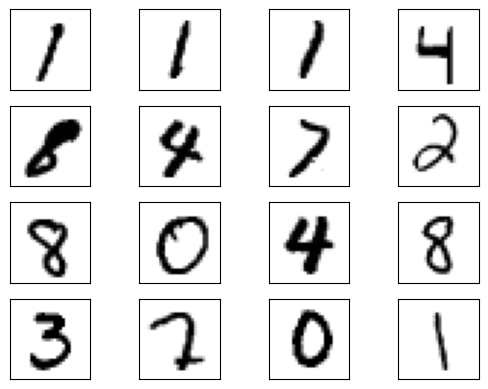

In [3]:
torch.manual_seed(111)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

#Visualize train data:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

Generator and Discriminator model architecture:

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [9]:
gen = Generator().to(device=device)
dis = Discriminator().to(device=device)

#Hyperparameters:
lr = 0.0001
num_epochs = 50
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(dis.parameters(), lr=lr)
optimizerG = torch.optim.Adam(gen.parameters(), lr=lr)
generated_samples = []

for epoch in range(num_epochs):

  for i, data in enumerate(train_loader):
    dis.zero_grad()

    real_sample, _ = data
    real_sample = real_sample.to(device=device)
    target_real = torch.ones((batch_size,1)).to(device=device)
    output_real = dis(real_sample)
    errdis_real = criterion(output_real, target_real)

    noise = torch.randn((batch_size, 100)).to(device=device)
    fake_sample = gen(noise)
    target_fake = torch.zeros((batch_size,1)).to(device=device)
    output_fake = dis(fake_sample.detach())
    errdis_fake = criterion(output_fake, target_fake)

    errdis = errdis_real + errdis_fake
    errdis.backward()
    optimizerD.step()

    gen.zero_grad()
    target_gen = torch.ones((batch_size,1)).to(device=device)
    output_gen = dis(fake_sample)
    errgen = criterion(output_gen, target_gen)
    errgen.backward()
    optimizerG.step()


    if epoch % 10 == 0 and i == batch_size - 1:
      print(f"Epoch: {epoch} Loss D.: {errdis.item()}")
      print(f"Epoch: {epoch} Loss G.: {errgen.item()}")

  noise_samples = torch.randn(batch_size, 100).to(device=device)
  generated = gen(noise_samples)
  generated_samples.append(generated.cpu().detach())

Epoch: 0 Loss D.: 1.0108792781829834
Epoch: 0 Loss G.: 0.576927900314331
Epoch: 10 Loss D.: 0.9164255857467651
Epoch: 10 Loss G.: 1.5012205839157104
Epoch: 20 Loss D.: 1.2966511249542236
Epoch: 20 Loss G.: 1.4360617399215698
Epoch: 30 Loss D.: 1.1513370275497437
Epoch: 30 Loss G.: 1.035715103149414
Epoch: 40 Loss D.: 1.2619712352752686
Epoch: 40 Loss G.: 1.0048398971557617


Display the final handwritten digits image

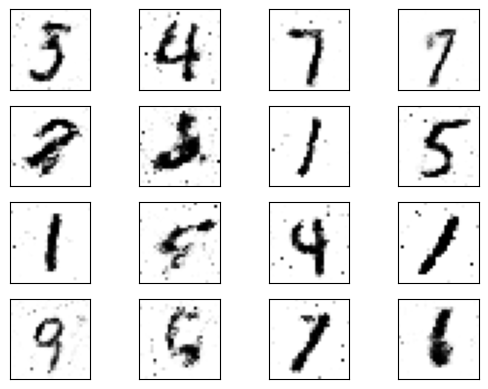

In [19]:
final = len(generated_samples)-1
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(generated_samples[final][i].reshape(28, 28), cmap="gray_r")
  plt.xticks([])
  plt.yticks([])

Observe the generated samples over the epochs:

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import imageio

frames = []

for gen_sample in generated_samples:
    fig, axs = plt.subplots(4, 4, figsize=(5, 5))
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        if i < len(gen_sample):
            ax.imshow(gen_sample[i].reshape(28, 28), cmap="gray_r")
        ax.axis('off')

    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(frame)

    plt.close(fig)

# Save the frames as a GIF
output_filename = "generated_samples.gif"
imageio.mimsave(output_filename, frames, fps=2)

print(f"GIF saved as {output_filename}")

<ipython-input-20-83b5a084281f>:17: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


GIF saved as generated_samples.gif


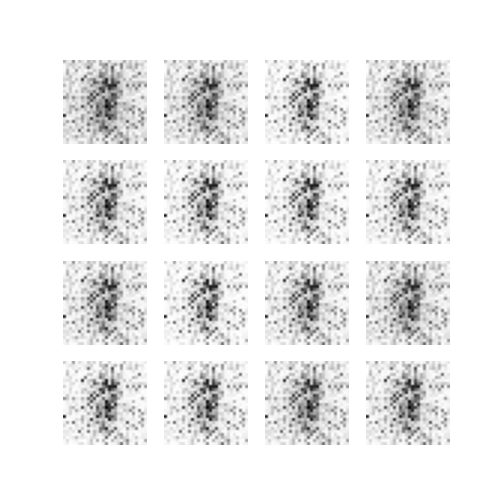

In [21]:
display(Image(output_filename))